In [1]:
from collections import Counter
import cv2
import os
import glob
import skimage
import numpy as np
import pandas as pd
import seaborn as sn
import preprocessing
from tqdm import tqdm
from PIL import Image
from os import listdir
import matplotlib.pyplot as plt
from skimage.transform import resize
from collections import Counter

sn.set()
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC # SVC
from sklearn import metrics
from sklearn.utils import shuffle
from xgboost import XGBClassifier # XGBClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,f1_score,recall_score,cohen_kappa_score,precision_score
from sklearn.utils import compute_class_weight
from sklearn.preprocessing import MinMaxScaler,LabelBinarizer
from sklearn.ensemble import AdaBoostClassifier # AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier # KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier # RandomForestClassifier
from sklearn.model_selection import train_test_split

import tensorflow 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16 # VGG16
from tensorflow.keras.applications.vgg19 import VGG19 # VGG19
from tensorflow.keras.applications.resnet50 import ResNet50 # ResNet50
from tensorflow.keras.applications.xception import Xception # Xception
from tensorflow.keras.applications.mobilenet import MobileNet # MobileNet
from tensorflow.keras.applications.nasnet import NASNetMobile # NASNetMobile
from tensorflow.keras.applications.densenet import DenseNet169 # DenseNet169
from tensorflow.keras.applications.densenet import DenseNet121 # DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 # MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3 # InceptionV3
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Flatten, Activation, GlobalAveragePooling2D,Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [9]:
no_angles = 360
url ='/kaggle/input/mias-mammography/all-mias'

In [10]:
def save_dictionary(path, data):
    print('saving catalog...')
    import json
    with open(path, 'w') as outfile:
        json.dump(str(data), fp=outfile)
    print('catalog saved')

In [11]:
def read_image():
    print("Reading images")
    import cv2
    info = {}
    for i in range(322):
        if i < 9:
            image_name = 'mdb00' + str(i + 1)
        elif i < 99:
            image_name = 'mdb0' + str(i + 1)
        else:
            image_name = 'mdb' + str(i + 1)
        image_address = os.path.join(url, image_name + '.pgm')
        img = cv2.imread(image_address, 1)
        img = cv2.resize(img, (224, 224))
        rows, cols, color = img.shape
        info[image_name] = {}
        for angle in range(0, no_angles, 8):
            M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
            img_rotated = cv2.warpAffine(img, M, (cols, rows))
            info[image_name][angle] = img_rotated
    return info

In [12]:
def read_label():
    print("Reading labels")
    filename = os.path.join(url, 'Info.txt')
    text_all = open(filename).read()
    lines = text_all.split('\n')
    info = {}
    for line in lines:
        words = line.split(' ')
        if len(words) > 3:
            if words[3] == 'B':
                info[words[0]] = {}
                for angle in range(0, no_angles, 8):
                    info[words[0]][angle] = 0
            elif words[3] == 'M':
                info[words[0]] = {}
                for angle in range(0, no_angles, 8):
                    info[words[0]][angle] = 1
    return info

lable_info = read_label()
image_info = read_image()


Reading labels
Reading images


In [14]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np

# Assuming read_lable() and read_image() functions are defined

lable_info = read_label()
image_info = read_image()

# Remove unnecessary key
del lable_info['Truth-Data:']

# Lists to store data
X = []
Y = []

# Populate X and Y
for id in lable_info.keys():
    for angle in range(0, no_angles, 8):
        X.append(image_info[id][angle])
        Y.append(lable_info[id][angle])

# Convert lists to numpy arrays
X = np.array(X)
Y = np.array(Y)

# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=2021, shuffle=True)

# Optionally, convert labels to categorical if needed
# y_train = to_categorical(y_train)
# y_test = to_categorical(y_test)

# Now you can proceed with your CNN model using x_train, y_train, x_test, and y_test
# Example:
# cancer_prediction_cnn(x_train, y_train, x_test, y_test)


Reading labels
Reading images


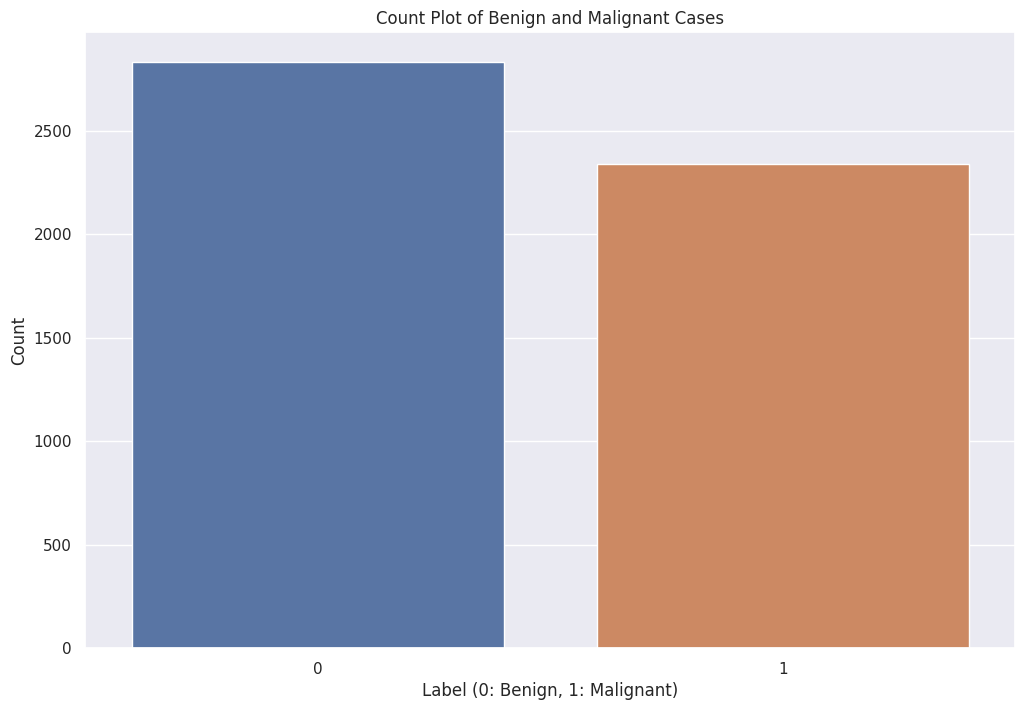

In [42]:
import os
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have the 'lable_info' dictionary with angle information
# and 'image_info' with the corresponding image data

# Flatten the 'lable_info' dictionary to create a DataFrame
data = {'ID': [], 'Angle': [], 'Label': []}

for id, angles in lable_info.items():
    for angle, label in angles.items():
        data['ID'].append(id)
        data['Angle'].append(angle)
        data['Label'].append(label)

df = pd.DataFrame(data)

# Plot count plot
plt.figure(figsize=(12, 8))
sns.countplot(x='Label', data=df)
plt.title('Count Plot of Benign and Malignant Cases')
plt.xlabel('Label (0: Benign, 1: Malignant)')
plt.ylabel('Count')
plt.show()


In [15]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPool2D, Flatten
from keras import optimizers
from keras import losses
from sklearn import metrics

rows, cols,color = x_train[0].shape
print(x_train[0].shape)

base_model = ResNet50(input_shape=(224,224,3), weights='imagenet', include_top=False)
x = base_model.output
x = Dropout(0.2)(x)
x = Flatten()(x)
predictions = Dense(8, activation='softmax')(x)

model_feat = Model(inputs=base_model.input,outputs=predictions)

train_features = model_feat.predict(x_train)
test_features=model_feat.predict(x_test)

(224, 224, 3)
25/25 [==============================] - 64s 3s/step


In [17]:
x_train_acc, x_val_acc, y_train_acc, y_val_acc = train_test_split(train_features,y_train,
                                                  test_size = 0.3,
                                                  stratify = y_train,
                                                  shuffle = True,
                                                  random_state = 42)
X_test,y_test=test_features,y_test

In [18]:
print('length X_train:', len(x_train_acc))
print('length y_train:', len(y_train_acc))

print('length X_val:',  len(x_val_acc))
print('length y_val:', len(y_val_acc))

print('length X_test:',  len(X_test))
print('length y_test:', len(y_test))

length X_train: 3078
length y_train: 3078
length X_val: 1320
length y_val: 1320
length X_test: 777
length y_test: 777


In [19]:
x_train_acc[0].shape

(8,)

In [20]:
names = [
        "K Nearest Neighbour Classifier",
        'SVM',
        "Random Forest Classifier",
        "AdaBoost Classifier", 
        "XGB Classifier",
         ]
classifiers = [
    KNeighborsClassifier(),
    SVC(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    XGBClassifier(),
        ]

zipped_clf = zip(names,classifiers)

In [33]:
from sklearn.metrics import confusion_matrix

def classifier_summary(pipeline, X_train, y_train, X_val, y_val, X_test, y_test):
    sentiment_fit = pipeline.fit(X_train, y_train)

    y_pred_train = sentiment_fit.predict(X_train)
    y_pred_val = sentiment_fit.predict(X_val)
    y_pred_test = sentiment_fit.predict(X_test)

    train_accuracy = np.round(accuracy_score(y_train, y_pred_train), 4) * 100
    train_precision = np.round(precision_score(y_train, y_pred_train, average='weighted'), 4)
    train_recall = np.round(recall_score(y_train, y_pred_train, average='weighted'), 4)
    train_F1 = np.round(f1_score(y_train, y_pred_train, average='weighted'), 4)
    train_kappa = np.round(cohen_kappa_score(y_train, y_pred_train), 4)
    train_confusion_matrix = confusion_matrix(y_train, y_pred_train)

    val_accuracy = np.round(accuracy_score(y_val, y_pred_val), 4) * 100
    val_precision = np.round(precision_score(y_val, y_pred_val, average='weighted'), 4)
    val_recall = np.round(recall_score(y_val, y_pred_val, average='weighted'), 4)
    val_F1 = np.round(f1_score(y_val, y_pred_val, average='weighted'), 4)
    val_kappa = np.round(cohen_kappa_score(y_val, y_pred_val), 4)
    val_confusion_matrix = confusion_matrix(y_val, y_pred_val)

    test_accuracy = np.round(accuracy_score(y_test, y_pred_test), 4) * 100
    test_precision = np.round(precision_score(y_test, y_pred_test, average='weighted'), 2)
    test_recall = np.round(recall_score(y_test, y_pred_test, average='weighted'), 2)
    test_F1 = np.round(f1_score(y_test, y_pred_test, average='weighted'), 2)
    test_kappa = np.round(cohen_kappa_score(y_test, y_pred_test), 2)
    test_confusion_matrix = confusion_matrix(y_test, y_pred_test)

    print('------------------------ Train Set Metrics------------------------')
    print("accuracy : {}%".format(train_accuracy))
    print("Confusion Matrix :\n", train_confusion_matrix)

    print('------------------------ Validation Set Metrics------------------------')
    print("accuracy : {}%".format(val_accuracy))
    print("Confusion Matrix :\n", val_confusion_matrix)

    print('------------------------ Test Set Metrics------------------------')
    print("accuracy : {}%".format(test_accuracy))
    print("F1_score : {}".format(test_F1))
    print("Cohen Kappa Score : {} ".format(test_kappa))
    print("Recall : {}".format(test_recall))
    print("Precision : {}".format(test_precision))
    print("Confusion Matrix :\n", test_confusion_matrix)

    print("-" * 80)

# Call the classifier_comparator function again
classifier_comparator(x_train_acc, y_train_acc, x_val_acc, y_val_acc, X_test, y_test, classifier=zipped_clf)


In [34]:
def classifier_comparator(X_train,y_train,X_val,y_val,X_test,y_test,classifier=zipped_clf): 
    result = []
    for n,c in classifier:
        checker_pipeline = Pipeline([('classifier', c)])
        print("Fitting {} on features ".format(n))
        #print(c)
        classifier_summary(checker_pipeline,X_train, y_train, X_val, y_val,X_test,y_test)

In [35]:
classifier_comparator(x_train_acc,y_train_acc,x_val_acc,y_val_acc,X_test,y_test,classifier=zipped_clf)

In [36]:
ann=Sequential()
ann.add(Dense(16,activation='relu',input_shape=x_train_acc[0].shape))
ann.add(Dense(32,activation='relu'))
ann.add(Dense(64,activation='relu'))
ann.add(Dense(64,activation='relu'))
ann.add(Dense(32,activation='relu'))
ann.add(Dense(16,activation='relu'))
ann.add(Dense(1,activation='sigmoid'))

ann.summary()

ann.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

history = ann.fit(x_train_acc, y_train_acc,validation_data=(x_val_acc,y_val_acc), epochs=20)

loss_value , accuracy = ann.evaluate(x_train_acc, y_train_acc)
print('Train_accuracy = ' + str(accuracy))
loss_value , accuracy = ann.evaluate(x_val_acc, y_val_acc)
print('Validation_accuracy = ' + str(accuracy))
loss_value , accuracy = ann.evaluate(X_test, y_test)
print('test_accuracy = ' + str(accuracy))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 16)                144       
                                                                 
 dense_9 (Dense)             (None, 32)                544       
                                                                 
 dense_10 (Dense)            (None, 64)                2112      
                                                                 
 dense_11 (Dense)            (None, 64)                4160      
                                                                 
 dense_12 (Dense)            (None, 32)                2080      
                                                                 
 dense_13 (Dense)            (None, 16)                528       
                                                                 
 dense_14 (Dense)            (None, 1)                

In [37]:
y_pred_probabilities = ann.predict(X_test)
y_pred = np.argmax(y_pred_probabilities, axis=1)

# Rest of your code remains the same
target = ["B", "M"]
print('Accuracy:', np.round(metrics.accuracy_score(y_test, y_pred), 4))
print('Precision:', np.round(metrics.precision_score(y_test, y_pred, average='weighted'), 4))
print('Recall:', np.round(metrics.recall_score(y_test, y_pred, average='weighted'), 4))
print('F1 Score:', np.round(metrics.f1_score(y_test, y_pred, average='weighted'), 4))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test, y_pred), 4))
print('\t\tClassification Report:\n', metrics.classification_report(y_test, y_pred, target_names=target))


25/25 [==============================] - 0s 1ms/step
Accuracy: 0.538
Precision: 0.2894
Recall: 0.538
F1 Score: 0.3764
Cohen Kappa Score: 0.0
		Classification Report:
               precision    recall  f1-score   support

           B       0.54      1.00      0.70       418
           M       0.00      0.00      0.00       359

    accuracy                           0.54       777
   macro avg       0.27      0.50      0.35       777
weighted avg       0.29      0.54      0.38       777



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:13

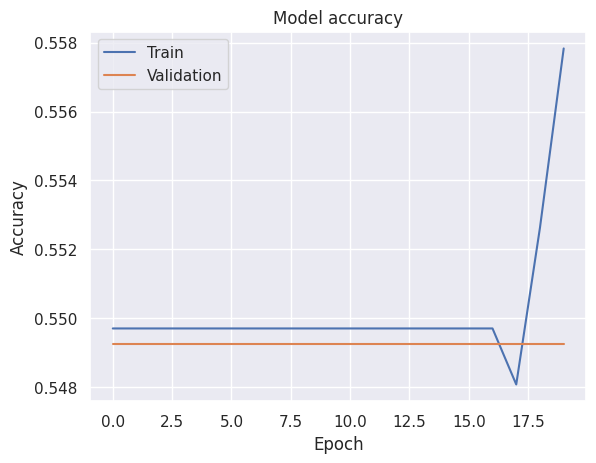

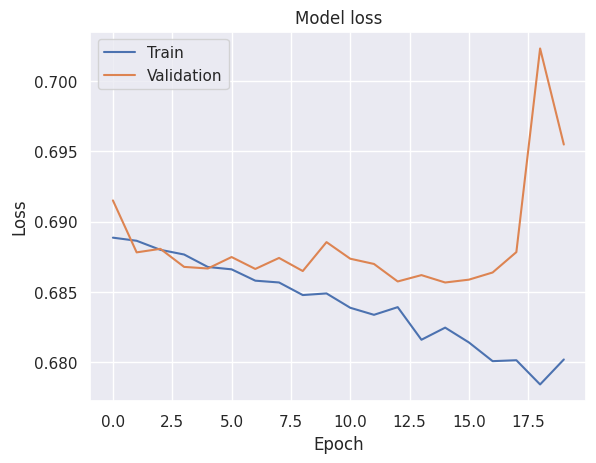

In [38]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
